In [ ]:
##Import all necessary libraries
import itertools
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
import seaborn as sns
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
sns.set()

In [ ]:
##first import the data into a pandas data-frame and inspect it’s properties
df = pd.read_csv("/content/mpg_raw.csv")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [ ]:
df.shape

(398, 9)

In [ ]:
##let's list all the columns
columns = list(df.columns)
columns

['mpg',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model_year',
 'origin',
 'name']

In [ ]:
##inspect meta-data (i.e., data about data), we can use an inbuilt pandas function.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [ ]:
cats = list(df.select_dtypes(include=['object']).columns)
nums = list(df.select_dtypes(exclude=['object']).columns)
print(f'categorical variables:  {cats}')
print(f'numerical variables:  {nums}')

categorical variables:  ['origin', 'name']
numerical variables:  ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']


In [ ]:
##inspect how many unique values are there in each column.
df.nunique(axis=0)


mpg             129
cylinders         5
displacement     82
horsepower       93
weight          351
acceleration     95
model_year       13
origin            3
name            305
dtype: int64

In [ ]:
##cylinders and model_year also seems to be categorical so lets update the lists
cats.extend(['cylinders', 'model_year'])
nums.remove('cylinders')
nums.remove('model_year')

print(f'categorical variables:  {cats}')
print(f'numerical variables:  {nums}')

categorical variables:  ['origin', 'name', 'cylinders', 'model_year']
numerical variables:  ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']


In [ ]:
# check for `nans` in each column
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

In [ ]:
# let's print these 6 `nan` containing rows 
df[df.isnull().any(axis=1)]


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
32,25.0,4,98.0,NaN,2046,19.0,71,usa,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,usa,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,europe,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,usa,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,europe,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,usa,amc concord dl


In [ ]:
# find total duplicate entries and drop them if any
print(f'total duplicate rows: {df.duplicated().sum()}')

total duplicate rows: 0


In [ ]:
# drop duplicate rows if any
df = df[~df.duplicated()]
df.shape

(398, 9)

In [ ]:
# remove extra spaces if any
for col in ['origin', 'name']:
    df[col] = df[col].apply(lambda x: ' '.join(x.split()))

df['mpg_level'] = df['mpg'].apply(lambda x: 'low' if x<17 else 'high' if x>29 else 'medium')
cats.append('mpg_level')
print(f'categorical variables:  {cats}')

categorical variables:  ['origin', 'name', 'cylinders', 'model_year', 'mpg_level']


In [ ]:
df = pd.concat((df[cats], df[nums]), axis=1)
df.head()

,origin,name,cylinders,model_year,mpg_level,mpg,displacement,horsepower,weight,acceleration
0,usa,chevrolet chevelle malibu,8,70,medium,18.0,307.0,130.0,3504,12.0
1,usa,buick skylark 320,8,70,low,15.0,350.0,165.0,3693,11.5
2,usa,plymouth satellite,8,70,medium,18.0,318.0,150.0,3436,11.0
3,usa,amc rebel sst,8,70,low,16.0,304.0,150.0,3433,12.0
4,usa,ford torino,8,70,medium,17.0,302.0,140.0,3449,10.5


In [ ]:
##Fisher’s exact test
ALPHA = 0.05
# Contingency Table (aka frequency table)
pd.crosstab(df.origin, df.model_year)

model_year,70,71,72,73,74,75,76,77,78,79,80,81,82
origin,,,,,,,,,,,,,
europe,5,4,5,7,6,6,8,4,6,4,9,4,2
japan,2,4,5,4,6,4,4,6,8,2,13,12,9
usa,22,20,18,29,15,20,22,18,22,23,7,13,20


In [ ]:
observed_values = pd.crosstab(df.origin, df.mpg_level).values
observed_values

array([[ 24,   2,  44],
       [ 49,   0,  30],
       [ 24,  90, 135]])

In [ ]:
chi2, p, dof, expected_values = stats.chi2_contingency(observed_values)
chi2, p, dof, expected_values

(124.67602279448344,
 5.353157991435908e-26,
 4,
 array([[ 17.06030151,  16.18090452,  36.75879397],
        [ 19.25376884,  18.26130653,  41.48492462],
        [ 60.68592965,  57.55778894, 130.75628141]]))

In [ ]:
if p <= ALPHA:
    print(f'Rejected H0 under significance level {ALPHA} `origin` & `model_year` are dependent.')
else:
    print(f'Fail to reject H0 due to lack of evidence under significance level {ALPHA} `origin` & `model_year` are independent.')
    

Rejected H0 under significance level 0.05 `origin` & `model_year` are dependent.


In [ ]:
##chi2 test available, let’s use it to test dependency of all categorical attributes with mpg_level .

df_cat_label =  pd.concat([df.loc[:, ['origin', 'mpg_level']].apply(lambda x: LabelEncoder().fit_transform(x)),
                           df.loc[: , 'cylinders': 'model_year']], axis=1)

df_cat_label.head()

,origin,mpg_level,cylinders,model_year
0,2,2,8,70
1,2,1,8,70
2,2,2,8,70
3,2,1,8,70
4,2,2,8,70


In [ ]:
chi2_res = feature_selection.chi2(df_cat_label, df.mpg_level)

df_chi2 = pd.DataFrame({
    'attr1': 'mpg_level',
    'attr2': df_cat_label.columns,
    'chi2': chi2_res[0],
    'p': chi2_res[1],
    'alpha': ALPHA
})

df_chi2['H0'] = df_chi2.p.apply(lambda x: 'rejected' if x <= ALPHA else 'fail to reject')
df_chi2['relation'] = df_chi2.H0.apply(lambda x: 'dependent' if x=='rejected' else 'independent')
df_chi2

,attr1,attr2,chi2,p,alpha,H0,relation
0,mpg_level,origin,29.860966,3.279244e-07,0.05,rejected,dependent
1,mpg_level,mpg_level,214.203922,3.063440e-47,0.05,rejected,dependent
2,mpg_level,cylinders,129.030964,9.578163e-29,0.05,rejected,dependent
3,mpg_level,model_year,22.195790,1.514417e-05,0.05,rejected,dependent


In [ ]:
##Statistical Tests for Numerical Attributes
nums = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


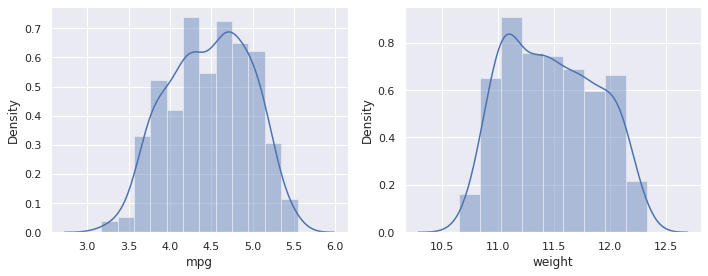

In [ ]:
##Visual Normality Checks
fig = pyplot.figure(1, (10, 4))

ax = pyplot.subplot(1,2,1)
sns.distplot(np.log2(df.mpg))
pyplot.tight_layout()

ax = pyplot.subplot(1,2,2)
sns.distplot(np.log2(df.weight))
pyplot.tight_layout()

pyplot.show()

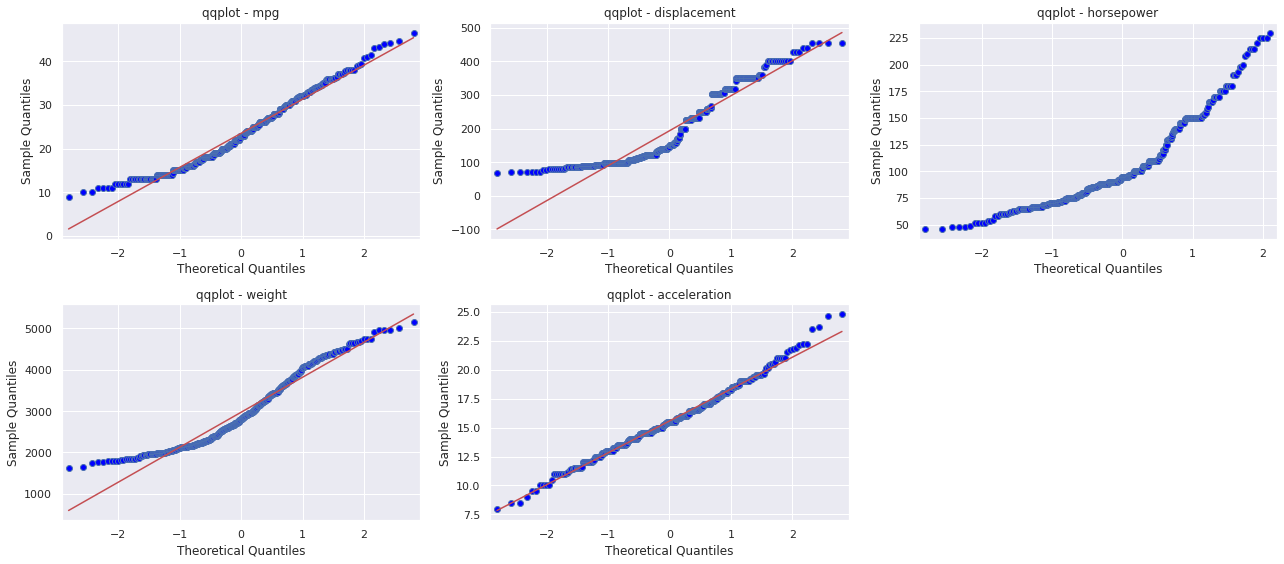

In [ ]:
# quantile-quantile plots on original data
fig = pyplot.figure(1, (18,8))

for i,num in enumerate(nums):
    ax = pyplot.subplot(2,3,i+1)
    qqplot(df[num], line= 's', ax=ax)
    ax.set_title(f'qqplot - {num}')
    pyplot.tight_layout()

In [ ]:
##Statistical Normality Tests
##Shapiro wilk test
def shapiro_wilk_test(df: pd.DataFrame, cols: list, alpha=0.05):
    # test the null hypothesis for columns given in `cols` of the dataframe `df` under significance level `alpha`.
    for col in cols:
        _,p = stats.shapiro(df[col])
        if p <= alpha:
            print(f'''\nRejected H0 under significance level {alpha}\n{col} doesn't seems to be normally distributed''')
        else:
          print(f'''\nFail to reject H0 due to lack of evidence under significance level {alpha}\n{col} seem to be normally distributed''')

     
_, p = stats.shapiro(df.acceleration)
p
shapiro_wilk_test(df, nums)




Rejected H0 under significance level 0.05
mpg doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
displacement doesn't seems to be normally distributed

Fail to reject H0 due to lack of evidence under significance level 0.05
horsepower seem to be normally distributed

Rejected H0 under significance level 0.05
weight doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
acceleration doesn't seems to be normally distributed


In [ ]:
##Power Transform
from sklearn.preprocessing import PowerTransformer

df_tfnum = pd.DataFrame(PowerTransformer().fit_transform(df[nums]), columns=nums)
df_tfnum.head()

,mpg,displacement,horsepower,weight,acceleration
0,-0.645513,1.129793,0.854984,0.754910,-1.327271
1,-1.152166,1.332841,1.443754,0.929331,-1.531864
2,-0.645513,1.185134,1.216062,0.689074,-1.740270
3,-0.975080,1.114248,1.216062,0.686130,-1.327271
4,-0.806477,1.103773,1.044925,0.701794,-1.952725


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

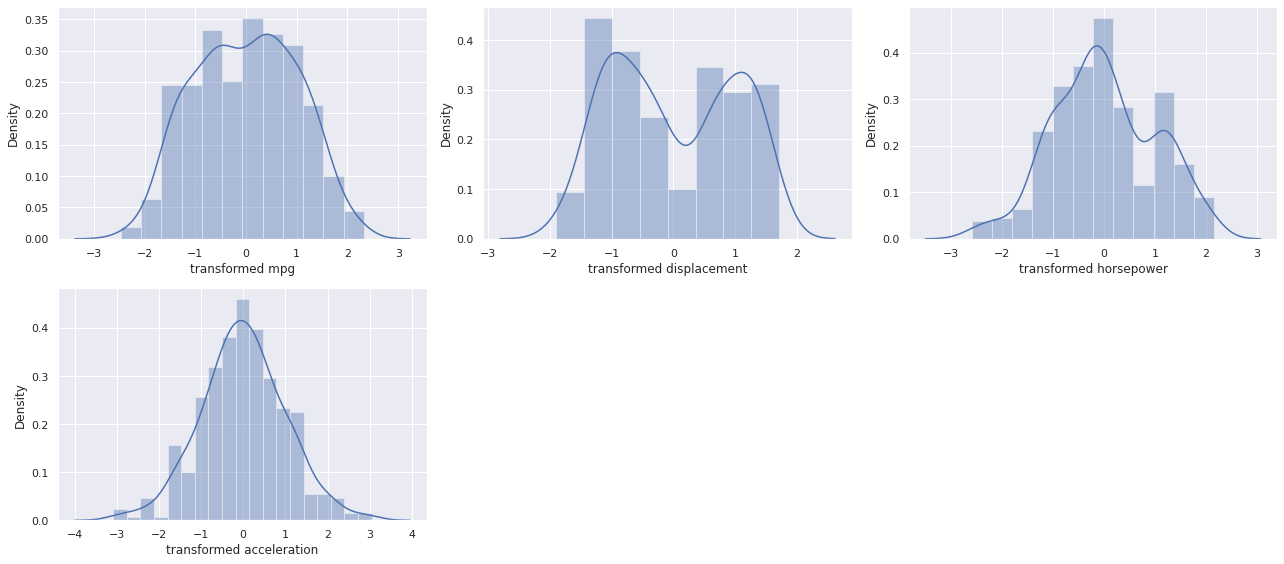

In [ ]:
##Plot Histogram
fig = pyplot.figure(1, (18,8))
for i,num in enumerate(['mpg', 'displacement', 'horsepower', 'acceleration']):
    ax = pyplot.subplot(2,3,i+1)
    sns.distplot(df_tfnum[num])
    ax.set_xlabel(f'transformed {num}')
    pyplot.tight_layout()


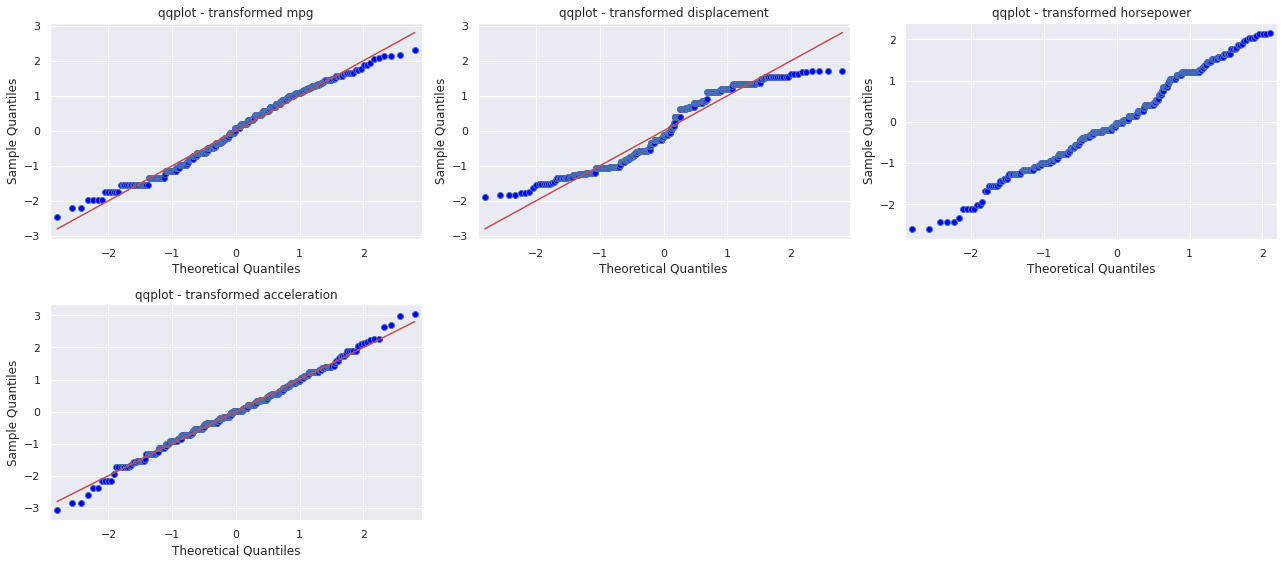

In [ ]:
##Plot quantile-quantile graph on transformed data
fig = pyplot.figure(1, (18,8))
for i,num in enumerate(['mpg', 'displacement', 'horsepower', 'acceleration']):
    ax = pyplot.subplot(2,3,i+1)
    qqplot(df_tfnum[num], line='s', ax=ax)
    ax.set_title(f'qqplot - transformed {num}')
    pyplot.tight_layout()
